## Hovmoller Sites NDVI

This notebook opens a shape file of transects, allows you to select a transect by number, and plot a hovmoller diagram of the site NDVI based on datacube landsat surface reflectance data and BoM rainfall data.

* if the time period is changed, you will need to re-save the data manually by changing 'savepath' so that files are not overwritten
* you will need to change coordinate reference system specs if the shapefile is not in Albers.
* rainfall data is currently in WGS84 due to datacube issues. This isn't a problem at the moment but could be later.


Dependencies:

  * shapefile of the site transects in EPSG 4326
  
  
The following sensors are available for the following time frames:
* Landsat 5 - 1986 to April 1999  followed by a gap until May 2003 - November 2011 (data from 2009 onwards becomes less reliable in southern Australia)
* Landsat 7 - April 1999 to present, however after May 2003 the scan line corrector (SLC) failed, 
so data are referred to as SLC-off, meaning they've got a venetian blinds appearance with wedges of missing data
  * This data is not well suited for inclusion in composites, but is fine to use in time series analysis
* Landsat 8 - April 2013 onwards
  
Bex Dunn april 2017


In [88]:
#in this notebook we want to plot non-interactively
%matplotlib inline

#get a bunch of modules to use

#suppress warnings thrown when rainfall data is imported
import logging
logging.getLogger('rasterio._gdal').setLevel(logging.ERROR)
import warnings

import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
import datetime as dt

import matplotlib as mpl
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
# import json
import pandas as pd
# from IPython.display import display
# import ipywidgets as widgets

from shapely.geometry import shape
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import os
import geopandas as gpd

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser as pq_fuser
from datacube.storage.masking import mask_invalid_data
import rasterio

###NEW FNS

%matplotlib inline

import sys

#modules for datacube
import datacube
from datacube.storage import masking
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser, write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
import DEAPlotting, DEADataHandling
from FileDialogs import *

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

dc = datacube.Datacube(app='dc-BoMrainfallandNbart')

### Set up functions for this notebook

In [159]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    gets the transect
    """
    #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)
def load_rainfall(query):
    
    dc_rf =datacube.Datacube(config='/g/data/r78/bom_grids/rainfall.conf')
    
    rf_data = dc_rf.load(product = 'rainfall_grids_1901_2017',**query)

    return rf_data

## add the path to the input shapefile

In [90]:
#transects file will be the file containing our transects
transects_file = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/transects/merged_hovmoller_transects.shp'
transects_df = gpd.read_file(transects_file)

## Define the epoch

In [91]:
#Define temporal range
start_of_epoch = '1986-10-01' 
end_of_epoch =  '2017-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 1986-10-01 to 2017-10-01


In [92]:
transects_df

I am densified (26 elements)
I am densified (26 elements)


,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,...,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,Shape_Leng,geometry
0,BasaltR_AmeliaDowns,None,None,None,None,None,1,0,-1,NaN,...,None,0,0,0.0,0,0,None,None,0.000000,LINESTRING (145.3654727229519 -19.677807946731...
1,Basalt R Bluff Downs,None,None,None,None,None,1,0,-1,NaN,...,None,0,0,0.0,0,0,None,None,0.000000,LINESTRING (145.5400705402667 -19.680736233093...
2,BasaltR_Cargoon,None,None,None,None,None,1,0,-1,NaN,...,None,0,0,0.0,0,0,None,None,0.000000,LINESTRING (144.8968212080451 -20.006890916131...
3,BasaltR_Ellenvale,None,None,None,None,None,1,0,-1,NaN,...,None,0,0,0.0,0,0,None,None,0.000000,LINESTRING (144.9768592509962 -19.918098521497...
4,BasaltR_JackoCk,None,None,None,None,None,1,0,-1,NaN,...,None,0,0,0.0,0,0,None,None,0.000000,LINESTRING (145.2763820545083 -19.724890628396...
5,BasaltR_junction,None,None,None,None,None,1,0,-1,NaN,...,None,0,0,0.0,0,0,None,None,0.000000,LINESTRING (145.8491857989452 -19.624168006552...
6,Bull paddock,None,None,None,None,None,1,0,-1,NaN,...,None,0,0,0.0,0,0,None,None,0.000000,LINESTRING (145.356858696472 -19.6635880051376...
7,Cuba plains,None,None,None,None,None,1,0,-1,NaN,...,None,0,0,0.0,0,0,None,None,0.000000,LINESTRING (145.0596251020021 -19.910665553793...
8,Expeditiion Ck,None,None,None,None,None,0,0,0,0.0,...,Expedition Ck Reedybrook.kmz,0,0,0.0,-1,0,None,None,0.013212,LINESTRING (145.0406904230001 -18.686156820999...
9,Felspar springs,None,None,None,None,None,0,0,0,0.0,...,Felspar springs.kmz,0,0,0.0,-1,0,None,None,0.053353,LINESTRING (145.2868481830001 -19.803869545999...


### Set up query

In [141]:
#use fiona module to open the shape file
transects = fiona.open(transects_file)

#this statement asks you to choose a shapefile. put in a number and press enter.
i = int(input("choose the index of the transect you would like to plot:"))
#for i in range(len(transects)):

geom1 = shape(transects[i]['geometry'])
geom_query1 = geom_query(geom1)
query = {
    'time': (start_of_epoch, end_of_epoch),  
}
query.update(geom_query(geom, geom_crs=transects.crs_wkt)) 

choose the index of the transect you would like to plot:1


In [142]:
query


{'time': ('1986-10-01', '2017-10-01'),
 'x': (145.27745648400003, 145.28684818300007),
 'y': (-19.85638916399995, -19.80386954599993),
 'crs': 'GEOGCS["GCS_WGS_1984",DATUM["WGS_1984",SPHEROID["WGS_84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295],AUTHORITY["EPSG","4326"]]'}

In [143]:
#use the transect dataframe to get transect metadata
transect_index = transects_df.index[i]
transect_name = transects_df['Name'][i] 
try:
    print(transect_name)
except TypeError as err:
    print("TypeError: {0}".format(err))
    print(transect_name)

#create a filename for the transect
shape_name = transect_name.split()
shape_name ='_'.join(shape_name)
shape_name=shape_name+'_ix'+str(transect_index)
print(shape_name)

#setup a save directory for our data
savepath ='/g/data/r78/rjd547/groundwater_activities/Burdekin/'+shape_name+'_/'
try:
        os.mkdir(savepath)
except OSError as err:
        print("OS error: {0}".format(err))

Basalt R Bluff Downs
Basalt_R_Bluff_Downs_ix1
OS error: [Errno 17] File exists: '/g/data/r78/rjd547/groundwater_activities/Burdekin/Basalt_R_Bluff_Downs_ix1_/'


In [144]:
#use our DEADataHandling function to load landsat data for all sensors in epoch and mask out cloudy scenes
ds = DEADataHandling.load_clearlandsat(dc, query,product='nbart',masked_prop=0.80)

Loading ls5 PQ
    Loading 239 filtered ls5 timesteps
Loading ls7 PQ
    Loading 52 filtered ls7 timesteps
Loading ls8 PQ
    Loading 60 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


### loop over transects, pull in rainfall and nbar from datacube and output hovmoller plots

In [160]:
#Grab bom_rainfall_grids from the datacube
Studysite_rain = load_rainfall(query)
print('loaded bom rainfall grids from datacube')

#make a dictionary of the data we want to save
# vars2pickle = {'Studysite_rain':Studysite_rain}
# f = open(savepath+'Rainfall_data'+'.pkl', 'wb')
# pickle.dump(vars2pickle,f) 
# print('saved rainfall data to file')
# #pickle.dump(vars2pickle,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
# f.close()   

loaded bom rainfall grids from datacube


In [161]:
#resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
#Note that the resampling we did means that each year is labelled according to its first day  
rain_sp = Studysite_rain.mean(dim = ('latitude','longitude'))
month_sp = rain_sp.resample('MS', dim = 'time', how = 'mean')
year_avg = Studysite_rain.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)
# Create a spatial average
year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
  after removing the cwd from sys.path.
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
  """


In [147]:
#     #make a dictionary of the data we want to save
#     pickle_vars = {'sensor1_nbar':sensor1_nbar,'sensor1_pq':sensor1_pq,
#               'sensor2_nbar':sensor2_nbar,'sensor2_pq':sensor2_pq,
#               'sensor3_nbar':sensor3_nbar,'sensor3_pq':sensor3_pq}

#     f = open(savepath+'NBARPQ_data'+'.pkl', 'wb')
#     pickle.dump(pickle_vars,f) 
#     print('saved sensor NBAR and PQ data to file')
#     #pickle.dump(pickle_vars,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
#     f.close()

In [162]:
#Set up some colour maps for the Hovmoller plots

#This controls the colour map used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

#Retrieve the hovmoller data volumes and concatenate them

In [151]:
geom_w = warp_geometry(geom, geom_query1['crs'], crs.wkt)
hov_ds= transect(ds, geom_w, 25)

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


In [163]:
#calculate NDVI here
hov_multi_ndvi = ((hov_ds.nir-hov_ds.red)/(hov_ds.nir+hov_ds.red))

In [165]:
hov_multi =hov_ds

transect image: 


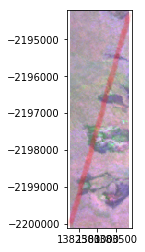

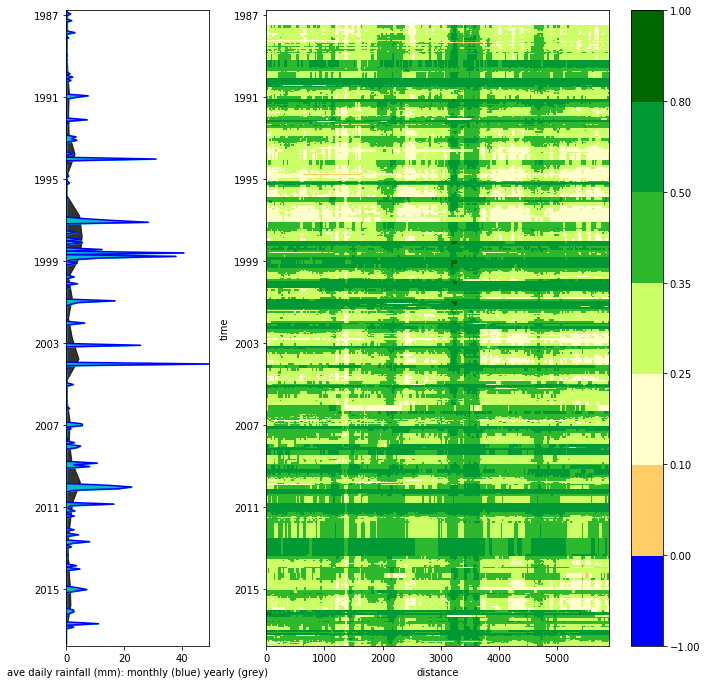

In [166]:
#calculate NDVI here
hov_multi_ndvi = ((hov_ds.nir-hov_ds.red)/(hov_ds.nir+hov_ds.red))
hov_multi =hov_ds
hov_multi_ndvi_drop = hov_multi_ndvi

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    rgb = ds.isel(time =10).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
    fake_saturation = 4500
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    plt.imshow(scaled, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])
    ##turn this one on to see where the transect is on the image!
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.05)
    plt.show()

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_multi_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_multi_ndvi_drop.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
plt.show()